In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../

import pylib.mix as mix
import pylib.Chebyschev_coefs as ch

17145
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(30):
    plt.close()

Function parameter:		 5.000e-02
Chosen function, parity:	 gauss, 0

Minimization method is used.
Computation status:  5.022306401140008e-16

Chosen polynomial's degree:	 120
Number of coefficients:		 60
max. abs. error: 2.507e-09


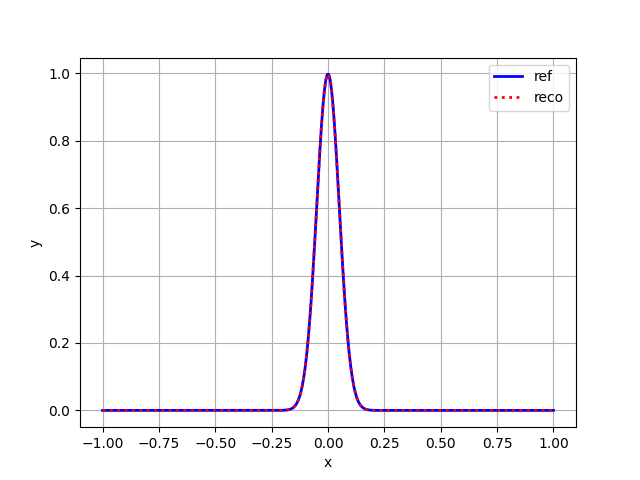

In [7]:
# ---------------------------------------------------
# --- Choose the function to approximate ---
# ---------------------------------------------------
mix.reload_module(ch)

# --- Choose the computational method ---
sel_method = 0

# --- Choose the function to approximate ---
id_fun = 3 # chosen function;
par1   = 0.05 # function parameter;

# --- Choose the polynomial degree ---
Nd = 120

# --- Computation ---
oo_ch_ = ch.Ch_()
oo_ch_.choose_method(sel_method)
oo_ch_.choose_func(id_fun, par1)
oo_ch_.compute_Ch(Nd)
oo_ch_.plot_reconstructed_function()

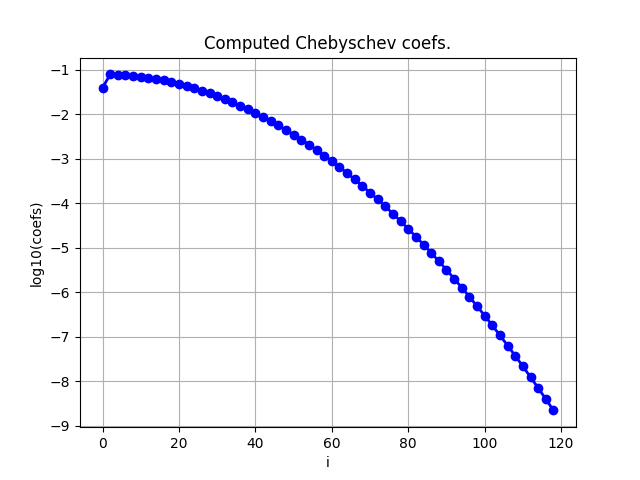

In [8]:
# ----------------------------------------------------
# --- Plot Chebyschev coefficients ---
# ----------------------------------------------------
oo_ch_.plot_coefficients()

In [9]:
# -----------------------------------------------------------------
# --- Store the coefficients into the .hdf5 file ---
# -----------------------------------------------------------------
oo_ch_.save_coefficients()

write coefficients to:
 ./tools/QSVT-angles/Gaussian/coefs//gauss_5_eps8.hdf5
